In [233]:
import pandas as pd
import json
import os

import math
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from collections import deque, defaultdict, Counter
import uuid

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics.pairwise import chi2_kernel
from sklearn.metrics import f1_score, precision_score, recall_score

%matplotlib inline

In [210]:
DATA_PATH = os.path.expanduser("~/data")

In [211]:
with open("{}/ast-tree-features.jsonl".format(DATA_PATH)) as f:
    raw = (entry.split("\t") for entry in f.readlines())
    labels = []
    features = []
    for label, ast in raw:
        labels.append(int(label))
        features.append( Counter(json.loads(ast)) )

## Features Description

Features are python counters. They come from AST stripped everything except node types. The stripped tree is normalized to a binary tree, and each occurance of `PARENT_TYPE|LEFT_NODE_TYPE|RIGHT_NODE_TYPE` is counted. Node types are encoded as integers, there are 40 node types in total.

In [212]:
features[10]

Counter({u'11|1|11': 2,
         u'11|1|14': 1,
         u'11|1|21': 1,
         u'11|1|40': 2,
         u'11|5|17': 2,
         u'11|5|40': 4,
         u'14|3|26': 1,
         u'14|3|35': 1,
         u'15|3|40': 4,
         u'16|40|15': 1,
         u'16|40|16': 30,
         u'16|40|19': 10,
         u'16|40|2': 2,
         u'16|40|21': 2,
         u'16|40|23': 1,
         u'16|40|30': 1,
         u'16|40|39': 2,
         u'16|40|5': 6,
         u'16|40|7': 2,
         u'17|11|26': 1,
         u'17|26|29': 1,
         u'17|3|11': 2,
         u'17|3|40': 1,
         u'19|40|16': 1,
         u'19|40|2': 1,
         u'1|16|40': 3,
         u'1|21|40': 3,
         u'20|16|40': 1,
         u'20|20|2': 1,
         u'20|20|40': 1,
         u'20|21|2': 1,
         u'20|21|40': 1,
         u'21|16|16': 6,
         u'21|16|2': 2,
         u'21|16|40': 17,
         u'21|16|7': 1,
         u'21|21|15': 1,
         u'21|21|16': 3,
         u'21|21|23': 1,
         u'21|21|40': 3,
         u'21|30|4

## Size and Shape of Dataset

In [213]:
n = len(labels)
Y = np.array(labels)

In [214]:
print "Dataset Size: {}".format(n)

Dataset Size: 22577


In [215]:
np.sum(Y) * 1.0 / n # roughly balanced examples

0.50073083226292248

In [216]:
test_size = int(math.floor(n * 0.15))
indices = np.random.permutation(n)
itrain, idev, itest = indices[test_size*2:], indices[:test_size], indices[test_size:test_size*2]

## Build "Vocabulary" of Features

In [217]:
all_types = Counter()
for f in features:
    for k in f.keys():
        all_types[k] += 1

In [218]:
def map_common_indices(counter, n):
    mapping = {}
    for i, (key, _) in enumerate(counter.most_common(n)):
        mapping[key] = i
    return mapping

## Use SVM to tune Hyperparameters 

We only keep the most common 600 tripplets.

In [92]:
dims = range(100, len(all_types), 100)

In [95]:
def tune(dimension):
    mapping = map_common_indices(all_types, dimension)
    X0 = np.zeros(dtype='int32', shape=[n, len(mapping)])
    # count features
    for i, f in enumerate(features):
        for k,v in f.iteritems():
            if k in mapping:
                X0[i, mapping[k]] = v
    # distance matrix
    X = np.zeros(dtype='float32', shape=[n, n])

    for i in xrange(n):
        for j in xrange(i, n):
            m = np.sum( np.abs(X0[i] - X0[j]) )
            X[i, j] = m
            X[j, i] = m
    # model
    mat = np.log(X+1.0)
    sims = 1 - mat/np.max(mat)

    x_train, x_dev = sims[itrain][:,itrain], sims[idev][:,itrain]
    y_train, y_dev = Y[itrain], Y[idev]

    svm = SVC(kernel='precomputed', probability=True)
    # clf = AdaBoostClassifier(svm)
    svm.fit(x_train, y_train)
    return svm, svm.score(x_dev, y_dev), X

In [96]:
best_score = 0.0
X = None
model = None
scores = []
for d in dims:
    mod, score, dists = tune(d)
    scores.append(score)
    if score > best_score:
        model = mod
        X = dists
        best_score = score
        print "Dim={} Score: {}".format(d, score)
    else:
        print "No improvement"

Dim=100 Score: 0.849333333333
No improvement
No improvement
No improvement
Dim=500 Score: 0.85
Dim=600 Score: 0.850666666667
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement


In [97]:
mat = np.log(X+1.0)
sims = 1 - mat/np.max(mat)
x_test = sims[itest][:,itrain]
y_test = Y[itest]
print "Score Test: {}".format(model.score(x_test, y_test))

Score Test: 0.84


## TfIDF Helper Functions

In [151]:
def tf_transform(features, vocab_mapping):
    tf = np.zeros(dtype='float32', shape=[len(features), len(vocab_mapping)])
    for i, f in enumerate(features):
        for t, count in f.iteritems():
            if t in vocab_mapping:
                tf[i, vocab_mapping[t]] = np.log(count + 1)
    return tf

def idf_transform(features, vocab_mapping):
    idf = np.zeros(dtype='float32', shape=[len(vocab_mapping)])
    for t in vocab_mapping:
        nd = np.sum(1.0 if t in f else 0.0 for f in features)
        idf[vocab_mapping[t]] = nd
    return np.log(len(features) / idf)

In [219]:
best_mapping = map_common_indices(all_types, 600)
X_tf = tf_transform(features, best_mapping)
idf  = idf_transform(features, best_mapping)
X_tfidf = np.apply_along_axis(lambda r:r*idf, 1, X_tf)

x_train, x_dev, x_test = X_tfidf[itrain], X_tfidf[idev], X_tfidf[itest]
y_train, y_dev, y_test = Y[itrain], Y[idev], Y[itest]

In [287]:
print x_train.shape

(15805, 600)


In [220]:
base_logistic = SGDClassifier(loss='log', penalty='l2')
base_logistic.fit(x_train, y_train)
base_logistic.score(x_test, y_test)

0.82220909627879502

In [239]:
def scores(mod, name, x_test, y_test):
    y_pred = mod.predict(x_test)
    print "{} Precision: {}".format(name, precision_score(y_test, y_pred))
    print "{} Recall: {}".format(name, recall_score(y_test, y_pred))
    print "{} F1: {}".format(name, f1_score(y_test, y_pred))

## Adaboosting of DecisionTrees 

* tune for `n_estimators` hyperparameter

(In general boosting > RandomForrest > bagging > Decision Tree)

In [223]:
best_score = 0.0
best_clf = None
for n_estimators in [50, 100, 150, 200]:
    clf = AdaBoostClassifier(DecisionTreeClassifier(), 
                                 s# algorithm='SAMME',
                             n_estimators=n_estimators)
    clf.fit(x_train, y_train)
    score = clf.score(x_dev, y_dev)
    if score > best_score:
        best_score = score
        best_clf = clf
        
best_clf

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None)

In [224]:
print "Score Train : {}".format(best_clf.score(x_train, y_train))
print "Score Dev : {}".format(best_clf.score(x_dev, y_dev))
print "Score Test: {}".format(best_clf.score(x_test, y_test))

Score Train : 0.982410629548
Score Dev : 0.90696987596
Score Test: 0.9161252215


In [241]:
scores(best_clf, "Decision Tree Adaboost", x_test, y_test)

Decision Tree Adaboost Precision: 0.934863523573
Decision Tree Adaboost Recall: 0.893831553974
Decision Tree Adaboost F1: 0.913887204366


## RandomForrest

* tune for `n_estimators` hyperparameter

In [225]:
best_score = 0.0
best_rf = None

for n_estimators in [20, 30, 40, 50, 60, 70, 80, 90, 100]:
    rf = RandomForestClassifier(n_estimators=n_estimators)
    rf.fit(x_train, y_train)
    score = rf.score(x_dev, y_dev)
    if score > best_score:
        best_rf = rf
        best_score = score

best_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [226]:
print "Score Train : {}".format(best_rf.score(x_train, y_train))
print "Score Dev : {}".format(best_rf.score(x_dev, y_dev))
print "Score Test: {}".format(best_rf.score(x_test, y_test))

Score Train : 0.982410629548
Score Dev : 0.911104548139
Score Test: 0.917897223863


In [240]:
scores(best_rf, "Random Forrest", x_test, y_test)

Random Forrest Precision: 0.943883984868
Random Forrest Recall: 0.887900355872
Random Forrest F1: 0.915036674817


In [227]:
# logistic regression with L2 regularization
clf = AdaBoostClassifier(SGDClassifier(loss='log', penalty='l2'), 
                         algorithm='SAMME',
                         n_estimators=100)
clf.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=100, random_state=None)

In [228]:
print "Score Train : {}".format(clf.score(x_train, y_train))
print "Score Dev : {}".format(clf.score(x_dev, y_dev))
print "Score Test: {}".format(clf.score(x_test, y_test))

Score Train : 0.825434988928
Score Dev : 0.830183106911
Score Test: 0.82516243355


In [229]:
tsne = TSNE(perplexity=50, n_components=2, n_iter=5000)
X2d = tsne.fit_transform(X_tfidf)

In [168]:
tsne = TSNE(perplexity=50, n_components=2, n_iter=5000, metric='precomputed')
X2d_dist = tsne.fit_transform(X)

In [284]:
flag,  = np.where(Y[itest]==1.0)
no_flag, = np.where(Y[itest]!=1.0)

In [255]:
y_pred = best_rf.predict(x_test)

In [267]:
where_flag,  = np.where(y_pred!=y_test)

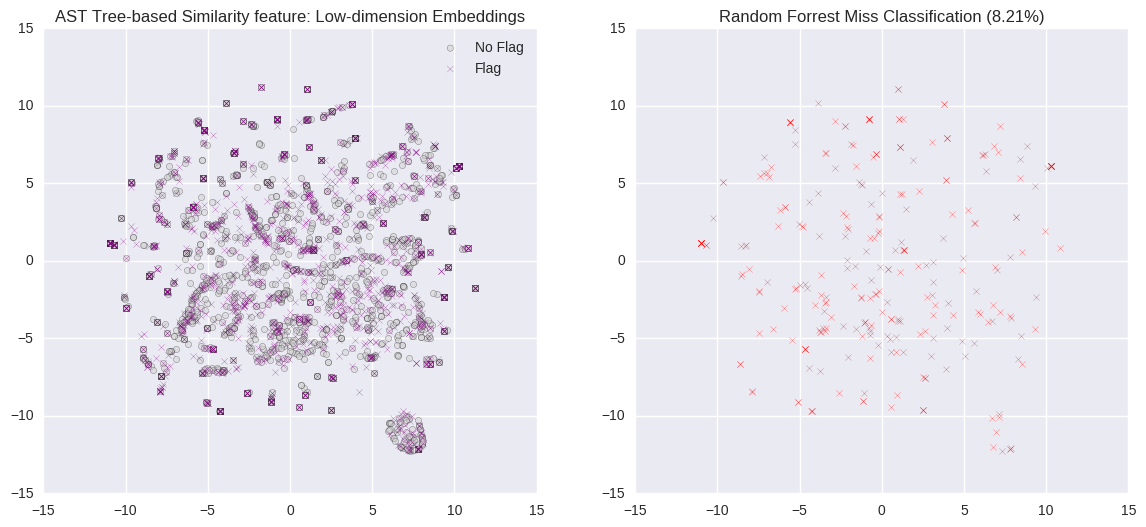

In [286]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax1.scatter(*X2d_dist[no_flag].T, c='lightgrey', marker='o', label='No Flag', alpha=0.5)
ax1.scatter(*X2d_dist[flag].T, c='purple', marker='x', label='Flag', alpha=0.5)
ax1.legend(loc='upper right')
ax1.set_title("AST Tree-based Similarity feature: Low-dimension Embeddings")

# ax2.scatter(*X2d_dist[p_no_flag].T, c='lightgrey', marker='o', label='No Flag', alpha=0.5)
ax2.scatter(*X2d_dist[where_flag].T, c='red', marker='x', label='Flag', alpha=0.5)
# ax2.legend(loc='upper right')
ax2.set_title("Random Forrest Miss Classification ({0:.2f}%)".format( len(where_flag) * 1.0 / len(itest) * 100 ))

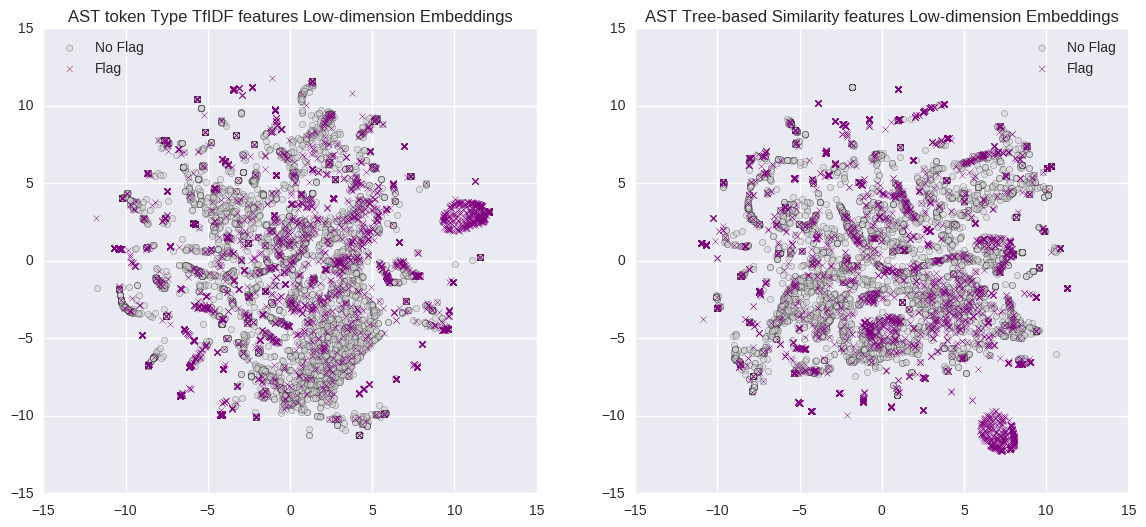

In [179]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
# ax1.scatter(*X2d[no_flag].T, c='lightgrey', marker='o', label='No Flag', alpha=0.5)
# ax1.scatter(*X2d[flag].T, c='purple', marker='x', label='Flag', alpha=1.0)
# ax1.legend(loc='upper left')
# ax1.set_title("AST token Type TfIDF features Low-dimension Embeddings")

ax2.scatter(*X2d_dist[no_flag].T, c='lightgrey', marker='o', label='No Flag', alpha=0.5)
ax2.scatter(*X2d_dist[flag].T, c='purple', marker='x', label='Flag', alpha=1.0)
ax2.legend(loc='upper right')
ax2.set_title("AST Tree-based Similarity features Low-dimension Embeddings")